In [ ]:
#Reference: SimpleITK documentation: https://simpleitk.readthedocs.io/en/master/

In [1]:
import SimpleITK as sitk
from downloaddata import fetch_data as fdata
%matplotlib notebook
import gui
import registration_gui as rgui

import numpy as np
import os
OUTPUT_DIR = 'output'

<IPython.core.display.Javascript object>


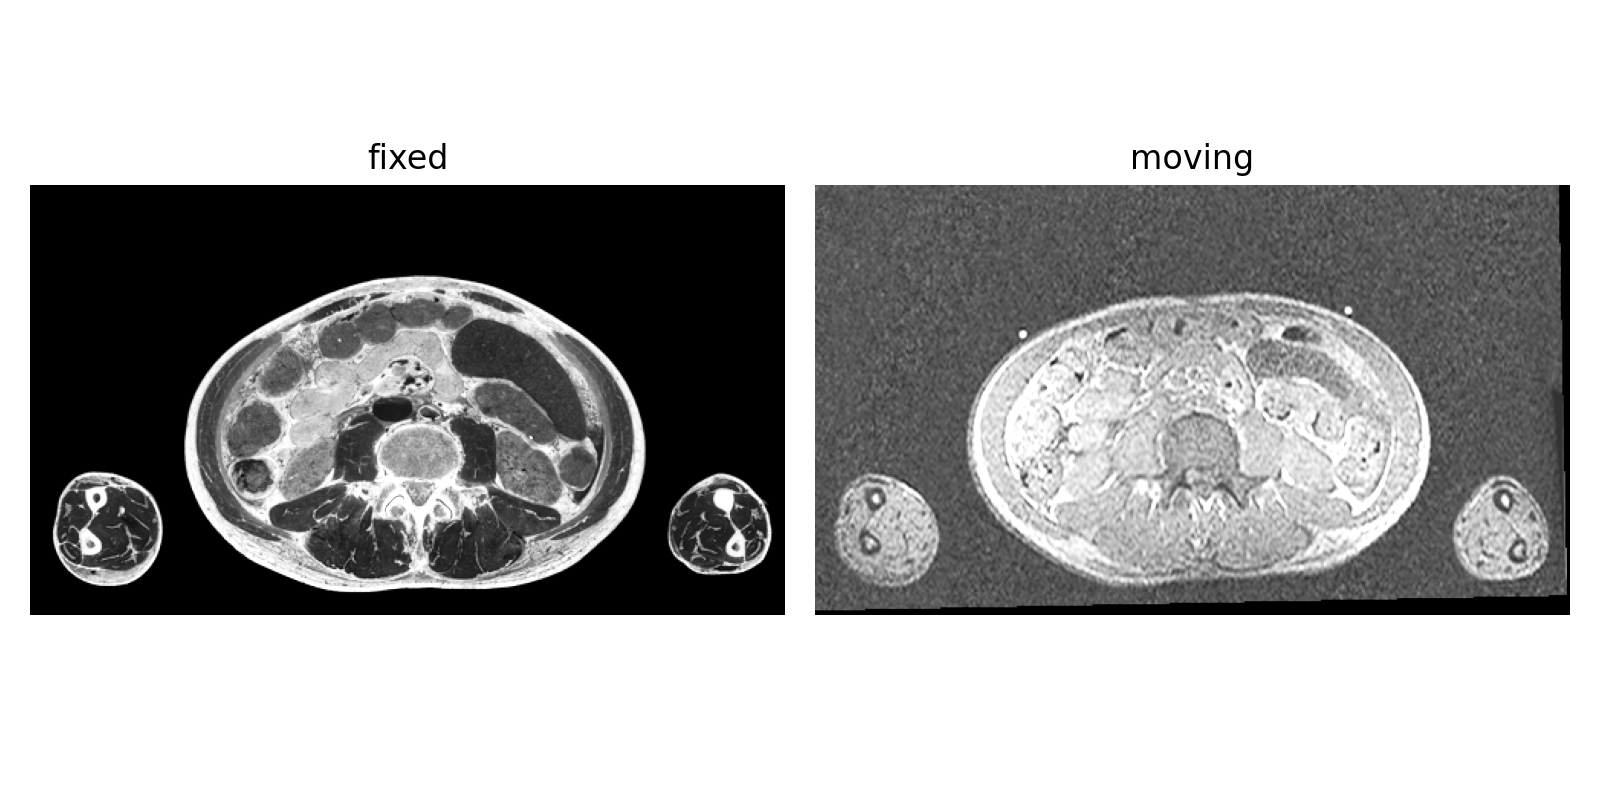

In [2]:
fixed_image =  sitk.ReadImage("/Users/pronomabanerjee/Desktop/subvolumes_abdomen/cryocleaned_abdomen_padded.mhd", sitk.sitkFloat32)
#moving_image = sitk.ReadImage("/Users/pronomabanerjee/Desktop/subvolumes_abdomen/CT_abdomen.mhd", sitk.sitkFloat32)
moving_image = sitk.ReadImage("/Users/pronomabanerjee/Desktop/subvolumes_abdomen/TUTORIAL/output/MRI_transformed_SITK1.mhd", sitk.sitkFloat32)

ct_window_level = [835,162]
mr_window_level = [1036,520]

gui.MultiImageDisplay(image_list = [fixed_image, moving_image],                   
                      title_list = ['fixed', 'moving'], figure_size=(8,4), window_level_list=[ct_window_level, mr_window_level]);

<IPython.core.display.Javascript object>


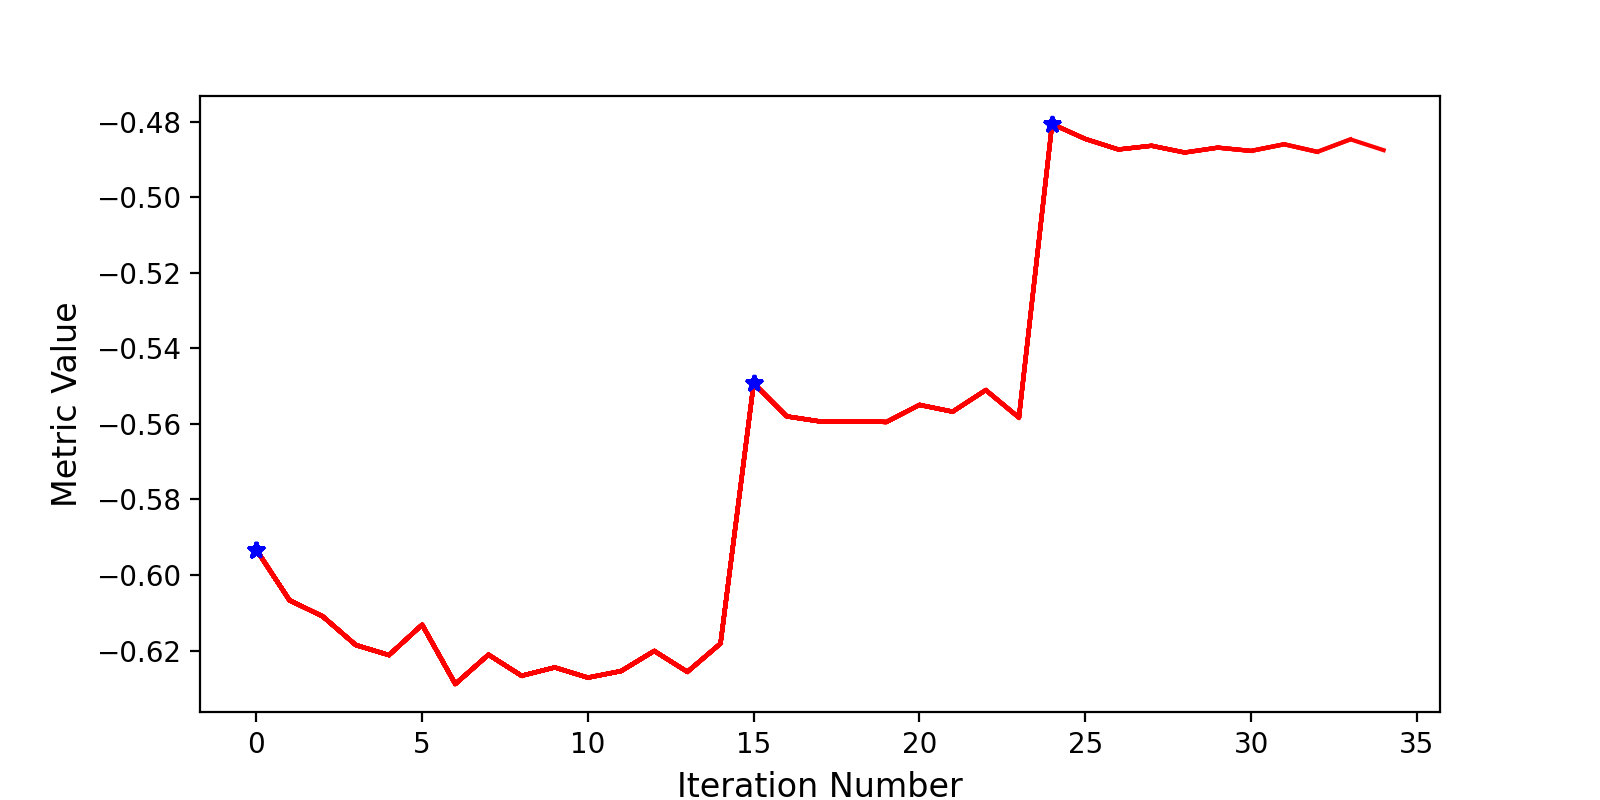

Final metric value: -0.4851800073790284
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 11.


In [4]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, rgui.start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, rgui.end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, rgui.update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rgui.plot_values(registration_method))

final_transform = registration_method.Execute(fixed_image, moving_image)

# Always check the reason optimization terminated.
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

In [8]:
def command_iteration(filter):
    print(f"{filter.GetElapsedIterations():3} = {filter.GetMetric():10.5f}")


'''if len(sys.argv) < 4:
    print(
        f"Usage: {sys.argv[0]} <fixedImageFilter> <movingImageFile> <outputTransformFile>")
    sys.exit(1)'''

fixed = fixed_image

moving = moving_image

matcher = sitk.HistogramMatchingImageFilter()
matcher.SetNumberOfHistogramLevels(1024)
matcher.SetNumberOfMatchPoints(7)
matcher.ThresholdAtMeanIntensityOn()
moving = matcher.Execute(moving, fixed)

# The basic Demons Registration Filter
# Note there is a whole family of Demons Registration algorithms included in
# SimpleITK
demons = sitk.DemonsRegistrationFilter()
demons.SetNumberOfIterations(50)
# Standard deviation for Gaussian smoothing of displacement field
demons.SetStandardDeviations(1.0)

demons.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(demons))

displacementField = demons.Execute(fixed, moving)

print("-------")
print(f"Number Of Iterations: {demons.GetElapsedIterations()}")
print(f" RMS: {demons.GetRMSChange()}")

outTx = sitk.DisplacementFieldTransform(displacementField)

sitk.WriteTransform(outTx, os.path.join(OUTPUT_DIR, "detailsdeform1mri.tfm"))

  1 = 1955.17121
  2 = 1918.14019
  3 = 1892.34256
  4 = 1872.86120
  5 = 1857.34863
  6 = 1844.51117
  7 = 1833.58645
  8 = 1824.12003
  9 = 1815.74438
 10 = 1808.22827
 11 = 1801.32629
 12 = 1795.00104
 13 = 1789.13100
 14 = 1783.68010
 15 = 1778.56500
 16 = 1773.80738
 17 = 1769.33911
 18 = 1765.14024
 19 = 1761.19717
 20 = 1757.47042
 21 = 1753.92175
 22 = 1750.57760
 23 = 1747.39681
 24 = 1744.37945
 25 = 1741.47467
 26 = 1738.69166
 27 = 1736.01431
 28 = 1733.45728
 29 = 1731.00230
 30 = 1728.63074
 31 = 1726.35051
 32 = 1724.12409
 33 = 1721.99207
 34 = 1719.92341
 35 = 1717.93808
 36 = 1715.99964
 37 = 1714.11835
 38 = 1712.29735
 39 = 1710.53098
 40 = 1708.81138
 41 = 1707.13831
 42 = 1705.53794
 43 = 1703.97683
 44 = 1702.46593
 45 = 1700.98072
 46 = 1699.54335
 47 = 1698.13718
 48 = 1696.78890
 49 = 1695.47172
 50 = 1694.18620
-------
Number Of Iterations: 50
 RMS: 0.20766015075852373


In [9]:
if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    #simg1 = sitk.Cast(sitk.RescaleIntensity(moving), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    # Use the // floor division operator so that the pixel type is
    # the same for all three images which is the expectation for
    # the compose filter.
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)

<IPython.core.display.Javascript object>


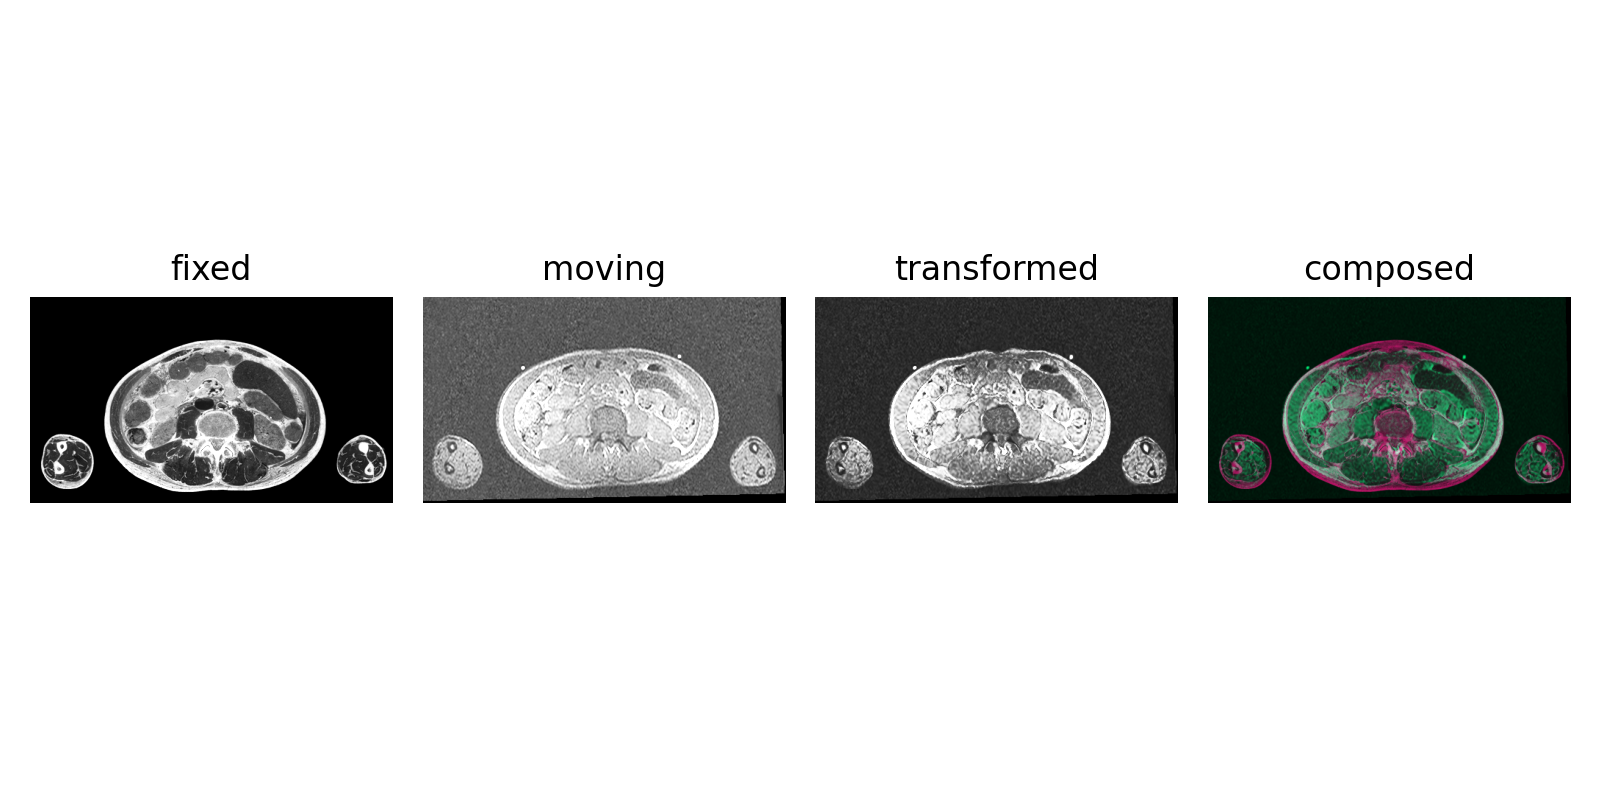

<IPython.core.display.Javascript object>


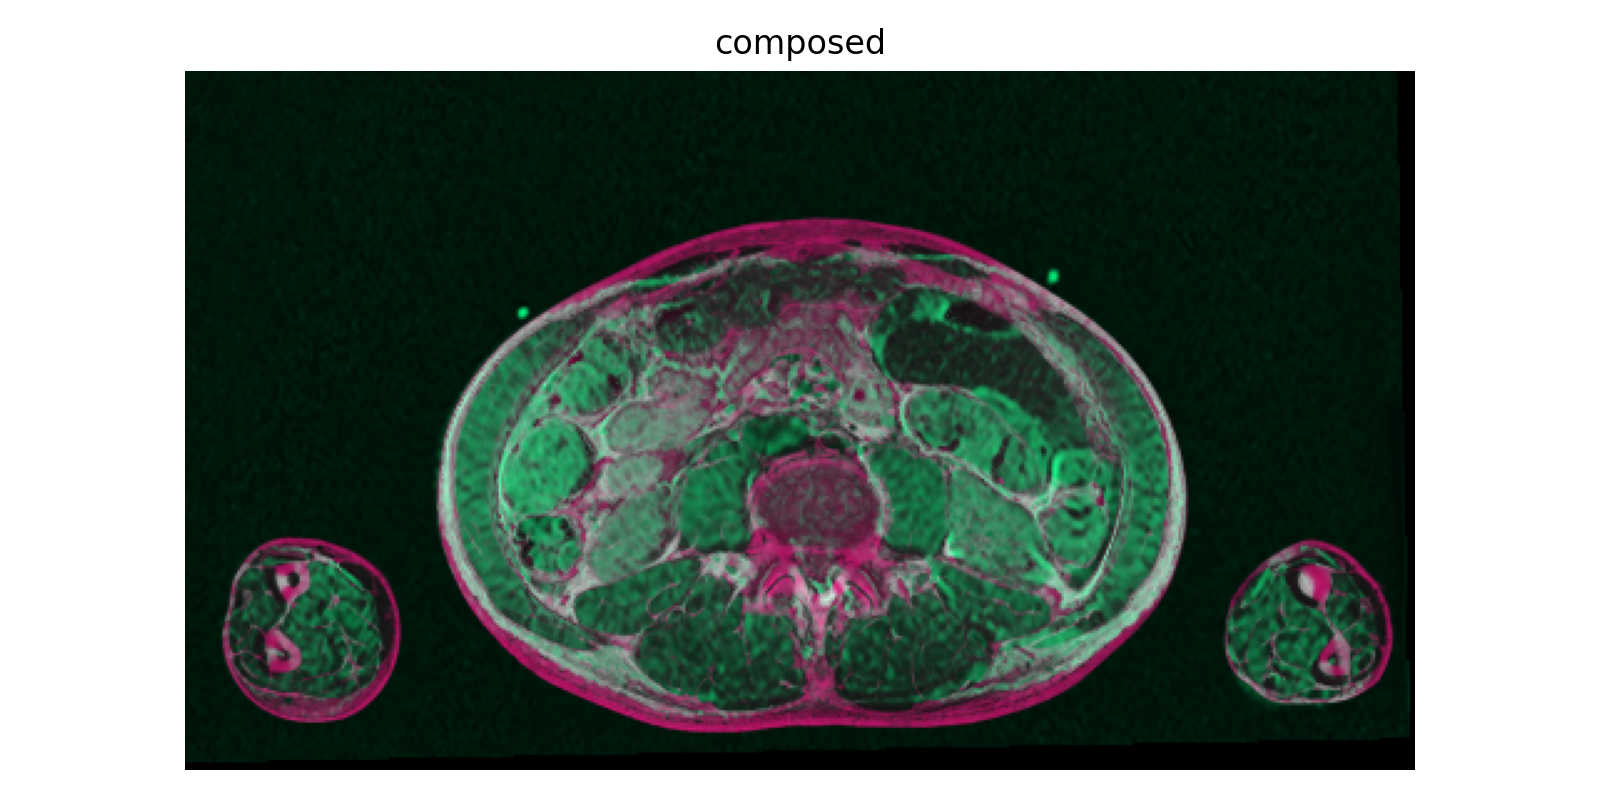

In [12]:
gui.MultiImageDisplay(image_list = [fixed_image, moving_image, out, cimg],                   
                      title_list = ['fixed', 'moving', 'transformed', 'composed'], figure_size=(8,4));


gui.MultiImageDisplay(image_list = [cimg],                   
                      title_list = ['composed'], figure_size=(8,4));

gui.MultiImageDisplay(image_list = [moving image],                   
                      title_list = ['composed'], figure_size=(8,4));

gui.MultiImageDisplay(image_list = [],                   
                      title_list = ['composed'], figure_size=(8,4));



In [46]:
sitk.WriteImage(out, os.path.join(OUTPUT_DIR, "MRI_demonsafterrigid1.mhd"))